# Analysis

The analysis modules contain functions to analyse MT data, for example analyse dimensionality or strike angle for either a single edi file or a collection of edi files.

## Look at the Phase Tensor

The phase tensor is an object within the MT object. So when you read in an edi file, it will automatically contain the phase tensor. To look at the attributes of the phase tensor, you can (as before) type mt_obj.[TAB] to see what is available. For example, to look at the skew angle (beta):

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
         0.,  3., 19., 19.,  5.,  4.,  4.,  1.,  2.,  1.,  1.]),
 array([-2.64957011e+01, -2.58646253e+01, -2.52335496e+01, -2.46024738e+01,
        -2.39713981e+01, -2.33403223e+01, -2.27092466e+01, -2.20781708e+01,
        -2.14470951e+01, -2.08160193e+01, -2.01849436e+01, -1.95538678e+01,
        -1.89227921e+01, -1.82917163e+01, -1.76606406e+01, -1.70295648e+01,
        -1.63984891e+01, -1.57674133e+01, -1.51363376e+01, -1.45052618e+01,
        -1.38741861e+01, -1.32431104e+01, -1.26120346e+01, -1.19809589e+01,
        -1.13498831e+01, -1.07188074e+01, -1.00877316e+01, -9.45665586e+00,
        -8.82558011e+00, -8.19450436e+00, -7.56342862e+00, -6.93235287e+00,
        -6.30127712e+00, -5.67020137e+00, -5.03912562e+00, -4.40804987e+00,
        -3.77697413e+00, -3.1458

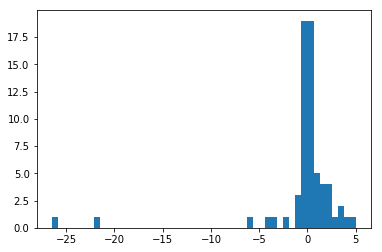

In [16]:
from mtpy.core.mt import MT
import matplotlib.pyplot as plt

# Define the path to your edi file and save path
edi_file = r"C:/mtpywin/mtpy/examples/data/edi_files_2/Synth00.edi"

mt_obj = MT(edi_file)

# look at the skew values as a histogram
plt.hist(mt_obj.pt.beta,bins=50)

## Look at dimensionality

Here, we use the phase tensor to determine which parts of the impedance tensor are 1D, 2D or 3D. The code returns an array with a value (1, 2 or 3) representing the dimensionality

In [8]:
# Import required modules
from mtpy.analysis.geometry import dimensionality
from mtpy.core.mt import MT
import os

# Define the path to your edi file and save path
edi_file = r"C:/mtpywin/mtpy/examples/data/edi_files_2/Synth00.edi"
savepath = r"C:/tmp"

# Create an MT object
mt_obj = MT(edi_file)

#Have a look at the dimensionality
print dimensionality(z_object = mt_obj.Z,
                     skew_threshold = 5, # threshold for 3D
                     eccentricity_threshold=0.1 # threshold for 2D
                     )

[2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 3 3 3]


## Look at strike angle

Here, we calculate the strike angle for the 2D part of the impedance tensor.

In [9]:
# Import required modules
from mtpy.analysis.geometry import strike_angle
from mtpy.core.mt import MT
import numpy as np
import os

# Define the path to your edi file and save path
edi_file = r"C:/mtpywin/mtpy/examples/data/edi_files_2/Synth00.edi"
savepath = r"C:/tmp"

# Create an MT object
mt_obj = MT(edi_file)

# calculate strike
strike = strike_angle(z_object = mt_obj.Z,
                    skew_threshold = 5, # threshold for 3D
                    eccentricity_threshold=0.1 # threshold for 2D
                   )

# display the median strike angle for this station
# two values because of 90 degree ambiguity in strike
print np.nanmedian(strike,axis=0)

[-3.98292164 86.01707836]


## Use dimensionality to mask an edi file

Here, we use the dimensionality calculated in Part 1 to mask all 3D parts of the impedance tensor and write to a new edi file.

In [11]:
# Import required modules
from mtpy.core.z import Z, Tipper
from mtpy.analysis.geometry import strike_angle
from mtpy.core.mt import MT
import os

# Define the path to your edi file and save path
edi_file = r"C:/mtpywin/mtpy/examples/data/edi_files_2/Synth00.edi"
savepath = r"C:/tmp"

# Create an MT object
mt_obj = MT(edi_file)

# Create an array (mask) with value True where the data are 1D or 2D and 
# False where the data are 3D
dim = dimensionality(z_object = mt_obj.Z,
                    skew_threshold = 5, 
                    eccentricity_threshold=0.1)
mask = dim < 3

# Apply masking. The new arrays z_array, z_err_array, and freq will
# exclude values where mask is False (i.e. the 3D parts)
new_Z_obj = Z(z_array=mt_obj.Z.z[mask],
                z_err_array=mt_obj.Z.z_err[mask],
                freq=mt_obj.Z.freq[mask])
new_Tipper_obj = Tipper(tipper_array=mt_obj.Tipper.tipper[mask],
                        tipper_err_array=mt_obj.Tipper.tipper_err[mask],
                        freq = mt_obj.Tipper.freq[mask])

# Write a new edi file (as before)
mt_obj.write_mt_file(save_dir=savepath, 
                    fn_basename='Synth00_mask3d', 
                    file_type='edi',
                    new_Z_obj=new_Z_obj,
                    new_Tipper_obj=new_Tipper_obj,
                    longitude_format='LONG',
                    latlon_format='dd')

'C:\\tmp\\Synth00_mask3d.edi'

##  Plot strike for a collection of files

In this example, we plot the strike as a rose plot for a collection of edi files. Strike is calculated from the Z invariants (after Weaver et al., 2000; 2003), the phase tensor (Caldwell et al. 2004) and the tipper. Plots can include all frequencies or be separated according to decade if you set plot_type = 1.

Reading 28 stations
-----Period Range 1e-05 to 1e+03 (s)-----
   *Z-Invariants:  median=125.2 mode=140.0 mean=140.0
   *PT Strike:     median=125.8 mode=140.0 mean=109.6
   *Tipper Stike:  median=109.5 mode=165.0 mean=99.9

Note: North is assumed to be 0 and the strike angle is measured clockwise positive.


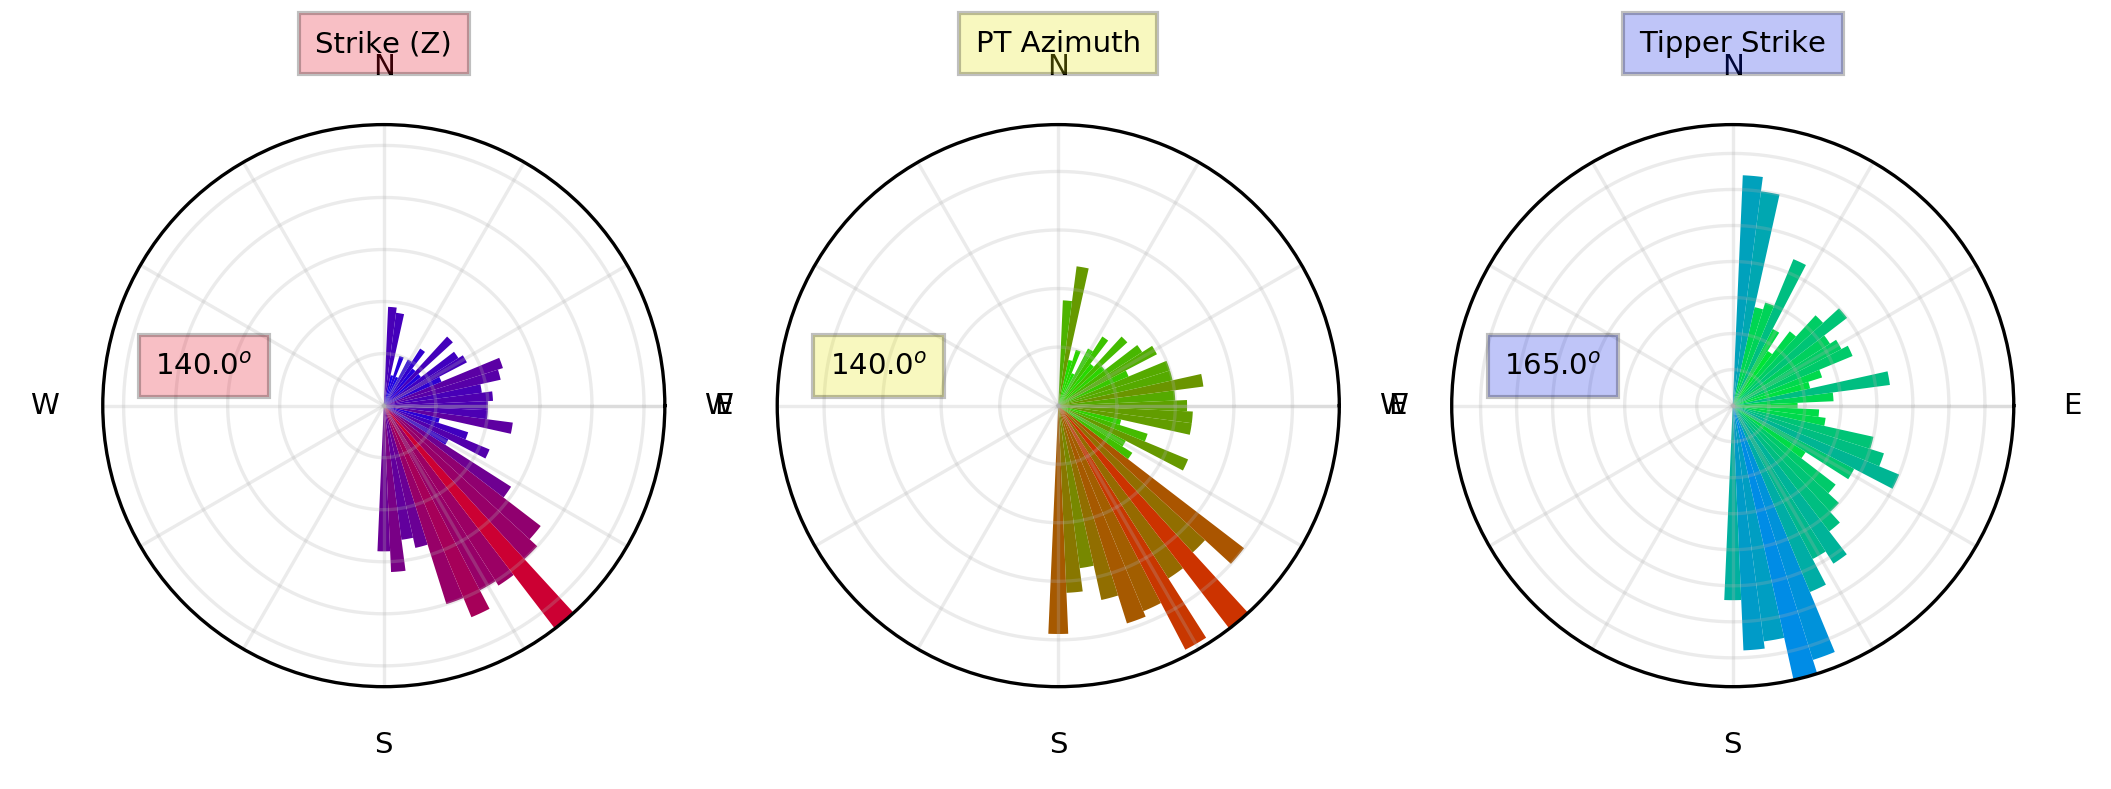

Saved figure to: C:/tmp\StrikeAnalysis.png


<Figure size 432x288 with 0 Axes>

In [26]:
# Import required modules
from mtpy.imaging.plotstrike import PlotStrike
import os

# Path containing edi files
edi_path = r'C:/mtpywin/mtpy/examples/data/edi_files_2'

# Full path to save path if you want to save the image
savepath = r'C:/tmp'

# Get full path to all files with the extension '.edi' in edi_path
edi_list = [os.path.join(edi_path,ff) for ff in os.listdir(edi_path) \
            if ff.endswith('.edi')]

# make a plot (try also plot_type = 1 to plot by decade)
strikeplot = PlotStrike(fn_list=edi_list, 
                        plot_type=2,
                       plot_tipper='y')

# save to file
strikeplot.save_plot(savepath,
                    file_format='.png',
                    fig_dpi=400)

## Rotating an edi file to strike and save to a new file

In the example below, we read an edi file, rotate it to a pre-defined strike and save it to a new file. Before saving the new edi file, we display the new rotation angle. This step can be omitted, but it is useful to check that the final rotation angle for the edi file is what you expect. Note there are multiple values for rotation angle representing each frequency contained in the edi file.

In [29]:
# Import required modules
from mtpy.core.z import Z, Tipper
from mtpy.analysis.geometry import strike_angle
from mtpy.core.mt import MT
import os

# Define the path to your edi file and save path
edi_file = r"C:/mtpywin/mtpy/examples/data/edi_files_2/Synth00.edi"
savepath = r"C:/tmp"

# Create an MT object
mt_obj = MT(edi_file)

# From a strike analysis of the whole dataset, we determine the
# strike is 140 degrees
strike = 140
mt_obj.Z.rotate(strike)
mt_obj.Tipper.rotate(strike)

# check the rotation angle
print mt_obj.Z.rotation_angle

# Write a new edi file (as before)
mt_obj.write_mt_file(save_dir=savepath, 
                    fn_basename='Synth00_rotate%1i'%strike, 
                    file_type='edi',
                    longitude_format='LONG',
                    latlon_format='dd')

[140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140.
 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140.
 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140.
 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140.
 140. 140. 140. 140. 140. 140. 140. 140. 140.]


'C:\\tmp\\Synth00_rotate140.edi'